# Physics 256
## Chaos in the Driven Dissipative Pendulum

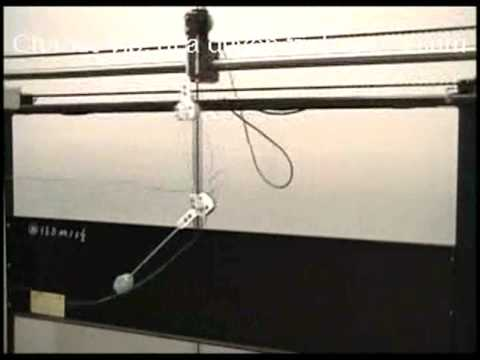

In [2]:
import style
style._set_css_style('../include/bootstrap.css')

from IPython.display import YouTubeVideo
# A driven double pendulum
YouTubeVideo('7DK1Eayyj_c')

## Last Time
### [Notebook Link: 16_SimpleHarmonicMotion](./16_SimpleHarmonicMotion)
- simple harmonic motion
- instability of the Euler method
- effects of non-linearities

## Today

- The driven dissipative  pendulum

## Setting up the Notebook

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('../include/notebook.mplstyle');
%config InlineBackend.figure_format = 'svg'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Dissipative Driven Pendulum

<img src='../data/pendulum.svg' width=500px>

## Equation of Motion

In the presence of external forces (including those that lead to non-conservation of energy) due to:

 * Gravity: $\;m g \hat{y}$
 * Dissipation: $\;-\gamma\; \vec{v}$
 * Motor: $\; F_\mathrm{D}(t) = F_\mathrm{D} \sin (\Omega_\mathrm{D} t) \hat{\theta}$

We can write down the equation of motion from Newton's law: $\; m \frac{d \vec{v}}{d t^2} = \vec{F} $

Since $x^2 + y^2 = \ell^2$ it is convenient to write everything in terms of the angle $\theta$:

$$ y = \ell \cos \theta $$
$$ x = \ell \sin \theta $$

In plane polar coordinates $\vec{r} = (r,\theta)$ where

\begin{align}
\hat{r} &= \cos \theta \hat{x} + \sin\theta \hat{y} \\
\hat{\theta} &= -\sin\theta \hat{x} + \cos\theta \hat{y}
\end{align}

and for $d r / dt = 0$ we have:

$$ \vec{v} = \ell \dot{\theta} \hat{\theta}$$

$$ \dot{\vec{v}} = -\ell \dot{\theta}^2 \hat{r} + \ell \ddot{\theta} \hat{\theta}$$

$$ \hat{y} = \cos \theta\; \hat{r} - \sin \theta\; \hat{\theta} $$

and measuring $\gamma$ and $F_D$ in terms of the mass $m$ the equation of motion in the $\hat{\theta}$ direction is:

\begin{equation}
\frac{d^2 \theta}{d t^2} = -\frac{g}{\ell}\sin\theta - \gamma \frac{d\theta}{d t} + F_\mathrm{D} \sin \Omega_\mathrm{D}t
\end{equation}

Last time, we solved this EOM using the Euler-Cromer method for the case of $\gamma = F_{\rm D} = 0$ and compared to the exact solution.

\begin{eqnarray}
\theta(t) &=& 2 \sin^{-1} \left\{ k\, \mathrm{sn}\left[K(k^2)-\sqrt{\frac{g}{\ell}} t; k^2\right] \right\} \newline
k &=& \sin \frac{\theta_0}{2} \newline
K(m) &=& \int_0^1 \frac{d z}{\sqrt{(1-z^2)(1-m z^2)}}
\end{eqnarray}

In [4]:
def non_linear_θ(ℓ,θ0,t):
    '''The solution for θ for the non-linear pendulum.'''
    # use special functions
    from scipy import special
    k = np.sin(θ0/2.0)
    K = special.ellipk(k*k)
    (sn,cn,dn,ph) = special.ellipj(K-np.sqrt(g/l)*t,k*k)
    return 2.0*np.arcsin(k*sn)

Text(0, 0.5, 'θ(t) [rad]')

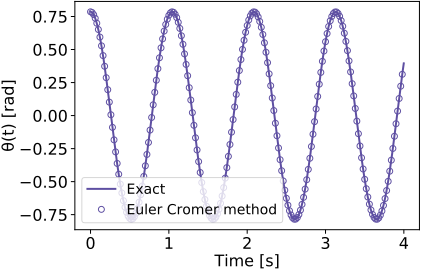

In [5]:
from scipy.constants import pi as π
from scipy.constants import g

# constants and intitial conditions
ℓ = 0.25 # m
Δt = 0.001 # s

t = np.arange(0.0,4.0,Δt)
θ,ω = np.zeros_like(t),np.zeros_like(t)
θ[0] = π/4.0 # rad

for n in range(t.size-1):
    θ[n+1] = θ[n] + ω[n]*Δt
    ω[n+1] = ω[n] -(g/ℓ)*np.sin(θ[n+1])*Δt

# the exact solution
plt.plot(t,non_linear_θ(ℓ,θ[0],t), color=colors[0],label='Exact')

# the Euler-Cromer method
plt.plot(t[::20],θ[::20], 'o', mfc='None', markersize = 6, mec=colors[0],label='Euler Cromer method')
plt.legend(loc='lower left',frameon=True)

plt.xlabel('Time [s]')
plt.ylabel('θ(t) [rad]')

## Adding Dissipation and the Driving Force

We are unable to find an analytical solution for the general case.  However, we can easily use the semi-implicit Euler method to compute an approximate solution.

\begin{eqnarray}
\frac{d \omega}{d t} &=& -\frac{g}{\ell}\sin\theta - \gamma \frac{d\theta}{d t} + F_\mathrm{D} \sin \Omega_\mathrm{D}t \newline
\frac{d\theta}{d t} &=& \omega.
\end{eqnarray}

For a time-step $\Delta t \ll 1$ we can approximate the continuous derviative using a discrete forward approximation:

\begin{eqnarray}
\omega_{n+1} &=& \omega_n - \frac{g}{\ell} \sin[\theta_n] \Delta t 
- \gamma \omega_n \Delta t + F_D \sin[\Omega_D t] \Delta t \newline
\theta_{n+1} &=& \theta_n + \omega_{n+1} \Delta t
\end{eqnarray}

In [6]:
from scipy.constants import g
from scipy.constants import pi as π
def euler(t,FD,ℓ,θ0,ω0,γ,ΩD):
    ''' Semi-implicit Euler Method for the non-linear, dissipative, driven pendulum.'''
    
    Δt = t[1]-t[0]
    ω,θ = np.zeros_like(t),np.zeros_like(t)
    θ[0],ω[0] = θ0,ω0
    
    # perform the numerical integration
    for n in range(t.size-1):
        ω[n+1] = ω[n] + (-(g/ℓ)*np.sin(θ[n]) - γ*ω[n] + FD*np.sin(ΩD*t[n]))*Δt
        θ[n+1] = θ[n] + ω[n+1]*Δt
        
        # keep theta in [-pi,pi)
        if θ[n+1] < -π: θ[n+1] += 2.0*π
        if θ[n+1] >= π: θ[n+1] -= 2.0*π 

    return θ,ω

### Determine how the driving force effects the time evolution

In [7]:
params = ℓ,θ0,ω0,γ,ΩD = g, 0.2, 0.0, 0.5, 2.0/3.0
FD = [0.0,0.5,0.75,1.0,1.25,1.5]
Δt = 0.04
t = np.arange(0.0,60,Δt)

#### No driving force: $F_{\mathrm{D}} = 0$

Text(0, 0.5, 'θ(t) [rad]')

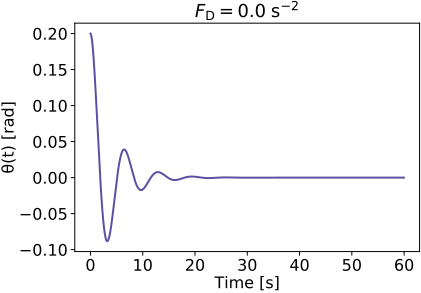

In [8]:
θ,ω = euler(t,0.0,*params)

plt.plot(t,θ)
plt.title(r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % 0.0)
plt.xlabel('Time [s]')
plt.ylabel('θ(t) [rad]')

#### Weak driving force

Text(0, 0.5, 'θ(t) [rad]')

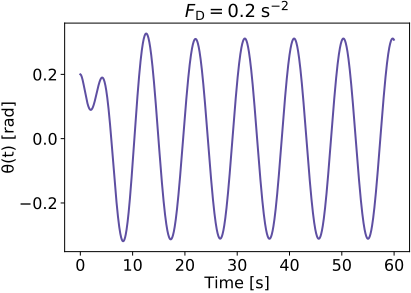

In [9]:
params = g, 0.2, 0.0, 0.5, 2.0/3.0
θ,ω = euler(t,0.2,*params)

plt.plot(t,θ)
plt.title(r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % 0.2)
plt.xlabel('Time [s]')
plt.ylabel('θ(t) [rad]')

### Let's investigate the explicit $F_\mathrm{D}$ dependence

[Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]')]

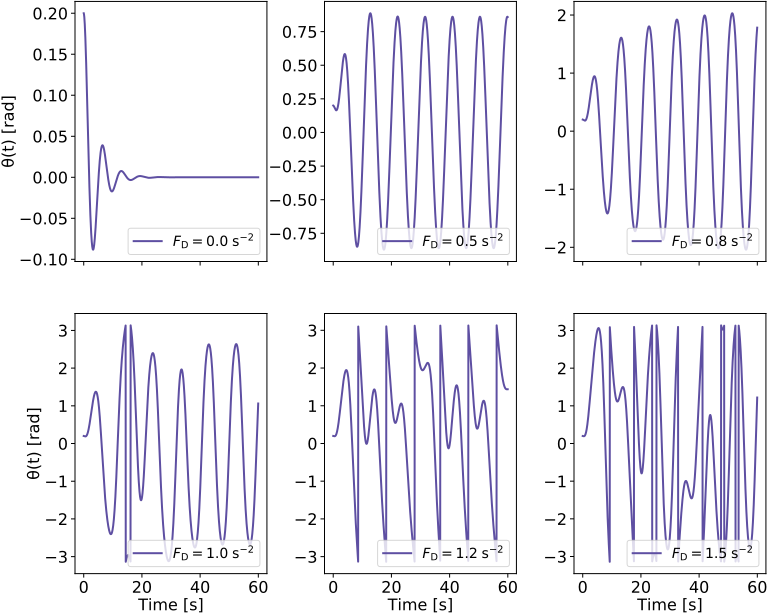

In [10]:
F = [0.0,0.5,0.75,1.0,1.25,1.5]

# create a subplot array
fig, axes = plt.subplots(2,3, figsize=(12,10), sharex=True)
fig.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axes.flat):
    θ,ω = euler(t,F[i],*params)
    ax.plot(t,θ, label=r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % F[i])
    ax.legend(frameon=True, loc='lower right')

# set axis labels
[ax.set_ylabel('θ(t) [rad]') for ax in axes[:,0]]
[ax.set_xlabel('Time [s]') for ax in axes[-1,:]]

## Understanding Chaos

 * What does **chaos** mean in this context?
 * It appears that when the driving force is strong, the angle as a function of time does not follow any predictable pattern.
 * However, we **CAN** predict it, as we have just calculated θ(t) via a numerical integration of the equation of motion.
 * This apparent contradiction is referred to as *deterministic chaos* and is common for non-linear ODE’s

This type of chaos is most easily understood in terms of the sensitivity of the trajectory on the initial conditions.

Text(0.5, 0, 'Time [s]')

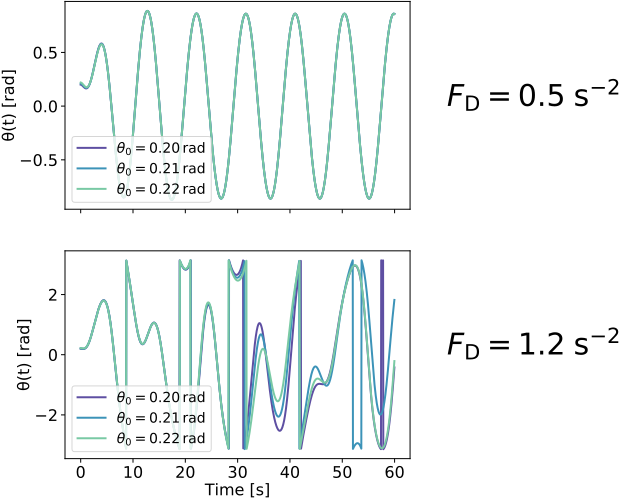

In [11]:
θ0 = [0.2,0.21,0.22] #  initial conditions
F = [0.5,1.2] # driving force

# compare the initial conditions
fig, axes = plt.subplots(2,1,sharex=True,sharey=False, figsize=(6,8))
for i, ax in enumerate(axes.flat):
    for j,cθ in enumerate(θ0):
        label = r'$\theta_0 = %4.2f\,\mathrm{rad}$' % cθ
        params = ℓ,cθ,ω0,γ,ΩD
        θ,ω = euler(t,F[i],*params)
        ax.plot(t,θ,label=label)
    ax.legend(frameon=True, loc='lower left')
    ax.text(70,0.0,r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % F[i],fontsize=30)
    
    # set axis labels
    ax.set_ylabel('θ(t) [rad]')

axes[-1].set_xlabel('Time [s]')

## Quantifying this Effect

 * We can try to quantify this effect by looking at the difference in angle at long times for two pendulums with nearly identical initial conditions.
 * Start them off with the same initial velocity, but with an initial angle difference of $\Delta \theta_0 = 0.0001$ radians.

Text(0.5, 0, 'Time [s]')

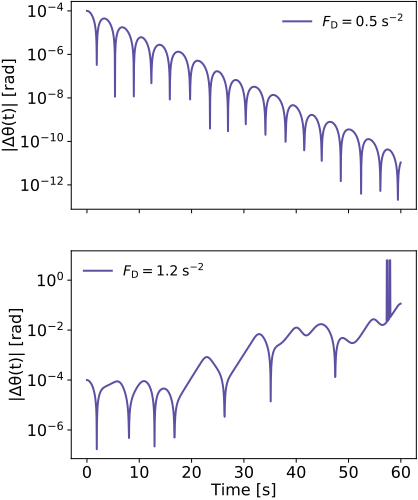

In [12]:
F = [0.5,1.2] # driving force [1/s^2]
θ0 = 0.2 # initial angle [rad]
params = [(ℓ,θ0,ω0,γ,ΩD),(ℓ,θ0+1.0E-4,ω0,γ,ΩD)]

Δθ = []
fig, axes = plt.subplots(2,1,sharex=True, sharey=False, squeeze=False, figsize=(6,8))
for i, ax in enumerate(axes.flat):
    label = r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % F[i]
    
    θ1,ω = euler(t,F[i],*params[0])
    θ2,ω = euler(t,F[i],*params[1])
    Δθ.append(np.abs(θ1-θ2))
    
    ax.semilogy(t, Δθ[i], label=label)
    ax.legend(loc='best', frameon=False)
    
    # set axis labels
    ax.set_ylabel('|Δθ(t)| [rad]')

axes[1,0].set_xlabel('Time [s]')

Note that the two regimes differ by the slope of the general linear trend on a log scale.

$$ \log \Delta \theta \sim \lambda t $$
$$ \Rightarrow \Delta \theta \propto \mathrm{e}^{\lambda t} $$

$\lambda$ is known as the Lyapunov exponent after Russian mathematician Aleksandr Lyapunov

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/Alexander_Ljapunow_jung.jpg" />

and can be used to characterize the sensitivity of a dynamic system to initial conditions.

$ \lambda > 0 \Rightarrow $ chaotic

$ \lambda < 0 \Rightarrow $ non-chaotic

Let's quantify this by trying to extract numerical values for the Lyapunov exponent.

We will use two methods from ```scipy```:

1. [scipy.signal.argrelextrema](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html):  Can find local minima and maxima.
2. [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html):  General curve-fitting.


In [17]:
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
F = [0.5,1.2]

# Linear fitting function
def linear(x,a0,a1):
    return a0 + a1*x

# find the local maxima and perform the fit
popt = [0,0]
for i,cF in enumerate(F):
    ind = argrelextrema(np.log(Δθ[i]),np.greater)[0]
    popt[i], pcov = curve_fit(linear,t[ind],np.log(Δθ[i][ind]))

#### Plot the results of the fit

In [ ]:
fig, axes = plt.subplots(2,1,sharex=True, sharey=False, squeeze=False, figsize=(6,8))
for i, ax in enumerate(axes.flat):
    labellam = r'$\lambda = %4.2f\; \mathrm{s}^{-1}$' % popt[i][1]
    
    ax.semilogy(t, Δθ[i], ',', markeredgewidth=0.0)
    ax.semilogy(t, np.exp(linear(t,*popt[i])), linewidth=3.0, label=labellam, color=colors[0])
      
    # set labels and legend
    ax.set_ylabel('|Δθ(t)| [rad]')
    ax.text(70,1.0E-6,r'$F_\mathrm{D} = %3.1f\; \mathrm{s}^{-2}$' % F[i],fontsize=30)
    ax.legend()
axes[1,0].set_xlabel('Time [s]')

### Code Re-Use

We keep needing to generate a label based on the driving force.  Let's write a function to do this:

In [ ]:
def FD_label(Fd):
    '''Create a label based on the value of FD'''
    return f'$F_\mathrm{{D}} = {F[i]:G}\; \mathrm{{s}}^{{-2}}$'

## Phase Space Plots

So far we have only analyzed the angle $\theta$ as a function of time, but there is information encoded in the angular velocity $\omega$ as well.  We can observe evidence of chaotic motion by looking at plots of $\theta$ vs $\omega$

<div class="span alert alert-warning">
   We are using <kbd>ax.text</kbd> and <kbd>transform=ax.transAxes</kbd> here to label our plots.
</div> 

In [ ]:
params = ℓ,θ0,ω0,γ,ΩD
F = [0.5,1.2]

fig, axes = plt.subplots(2,1,sharex=True, sharey=False, squeeze=False, figsize=(6,8))
for i, ax in enumerate(axes.flat):
    θ,ω = euler(t,F[i],*params)
    
    ax.plot(θ,ω,marker='o', linestyle='None', ms=1)
    
    # set axis labels and legends
    ax.set_ylabel('ω [rad/s]')
    ax.set_xlim(-π,π)
    ax.text(1.05,0.5,FD_label(F[i]),fontsize=30,transform=ax.transAxes)

axes[1,0].set_xlabel('θ(t) [rad]')

 * For a small driving force, we observe transients then relaxation into periodic motion.
 * For large driving force, the trajectory has many nearly closed orbits.

## Poincaré Section

<img src="https://upload.wikimedia.org/wikipedia/commons/4/45/Henri_Poincar%C3%A9-2.jpg" width=200px>

These nearly closed orbits are related to so-called **Strange Attractors** which can be found by looking at a phase space plot that is **in phase** with the driving force.  This is equivalent ot making a *stroboscopic* measurement.

$$ \Omega_\mathrm{D} t = 2 n \pi $$

where $n \in \mathbb{Z}$.  We can code this by creating a stride $m$ that is equivalent to the length of the period $T = 2\pi/\Omega_D$:

$$ p_{\rm step} = \left\lfloor \frac{T}{\Delta t} + \frac{1}{2} \right\rfloor $$

This is equivalent to only selecting those time steps when:
\begin{equation}
\left | t[n] - \frac{2 n \pi}{\Omega_D} \right| < \frac{\Delta t}{2} .
\end{equation}


### Generate a longer solution to include more phase-space data

In [ ]:
Δt = 2.0*π/(ΩD*100)
longt = np.arange(0,10000,Δt)

F = [0.5,1.2]
θ,ω = [],[]
for cF in F:
    th,w = euler(longt,cF,*params)
    θ.append(th)
    ω.append(w)

### Get the in-phase time slices

<div class="span alert alert-success">
<h2> Programming challenge </h2>
    Determine the stride value <kbd>pstep</kbd> corresponding to the in-phase times.
</div>

<!--
T = 2*π/ΩD
pstep = int(T/Δt + 0.5)
inPhaset = longt[::pstep]
-->

### Now we plot the actual Poincaré section

In [ ]:
pcol = colors[1],colors[-2]
plt.figure(figsize=(8,8))
for i in range(2):
    plt.plot(θ[i][::pstep], ω[i][::pstep], marker='o', color=pcol[i], ms=3, linestyle='None', label=FD_label(F[i]), alpha=0.5)
    
plt.title('Strange Attractors')
plt.legend(fontsize=16, handletextpad=0.2, markerscale=2)
plt.xlabel('θ [rad]')
plt.ylabel('ω [rad/s]')
plt.xlim(-π,π);

The Poincare section looks very different for the chaotic vs non-chaotic regime.

 * Two points in non-chaotic regime: 
    * Original periodic motion
    * Periodic motion, parallel to the driver 
 * In chaotic regime, we get a surface.
    * _Fuzziness_ not due to numerics: property of the system.
    * Largely independent of details of initial conditions.
    * Surface has a fractal dimension

### Let's take a look at how the chaotic behavior actuall emerges in this system.

<div class="span alert alert-warning">
    We are using not flatenning our plot axes here and thus <kbd>axes</kbd> is a $3 \times 1$ matrix.
</div> 

In [ ]:
F = [1.35, 1.44, 1.465] 
θ0 = 0.2
params = ℓ,θ0,ω0,γ,ΩD

fig, axes = plt.subplots(3,1,sharex=True, sharey=True, squeeze=False, figsize=(6,10))
for i, ax in enumerate(axes.flat):
        θ,ω = euler(t,F[i],*params)
        ax.plot(t, θ, label=FD_label(F[i]))
        ax.legend(loc="lower left", frameon=True, prop={'size':16})
    
        # set axis labels
        ax.set_ylabel('θ(t) [rad]')
        
axes[-1,0].set_xlabel('Time [s]')

 * As we increase the driving force, we observe that for special values of $F_\mathrm{D}$, the period doubles.
 * Periodic motion with frequencies $\Omega_\mathrm{D}/2, \Omega_\mathrm{D}/4 \ldots$
 * Striking phenomenon! Usually in non-linear systems we expect the appearance of higher harmonics: frequencies that are integer multiples of the driving frequency.

We can systematicaly study this effect via a **Bifurcation Diagram**.

 1. Study the angle $\theta$ as a function of time.
 2. After waiting until all transients have died away, we plot $\theta$ at times that are in phase with the driving force.
 3. Repeat for different values of the driving force. 
 
## Bifurcation Diagram

We want to analyze the long-time behavior of the system after all trasients have died out as a function of $F_\mathrm{D}$

In [ ]:
run = False
F = np.arange(0,1.5,0.0025)
if run:
    θ = np.zeros([len(longt[10*pstep::pstep]),len(F)])
    for i,cF in enumerate(F):
        th,ω = euler(longt,cF,*params)
        θ[:,i] = th[10*pstep::pstep]
    np.savetxt('../data/theta.dat',θ)
else:
    θ = np.loadtxt('../data/theta.dat')

In [ ]:
plt.figure(figsize=(7,7))
pF = np.ones_like(θ[:,0])
for i,cF in enumerate(F):
    u = np.unique(θ[:,i])
    pF = cF*np.ones_like(u)
    plt.plot(pF, u, marker='o', ms=3, linestyle='None', mfc=colors[1], mew=0, mec='None', alpha=1,rasterized=True) 

plt.ylabel('θ [rad]')
plt.xlabel(r'$F_\mathrm{D}\; [\mathrm{s}^{-2}]$')
plt.xlim(1.34,1.5);
plt.ylim(0,π);

### The Onset of Chaos

 * The bifurcation diagram gives us a feeling for how chaotic behavior is approached: a cascade of period doublings.
 * Is this behavior universal? We have yet to discuss why this doubling happens.
 * Define $F_n$ as the value of some parameter where the $n^{\mathrm{th}}$ period doubling occurs.

$$\delta_n = \frac{F_n - F_{n-1}}{F_{n+1}-F_n}$$

What happens when $n\to\infty$? We find a number called the **Universal Feigenbaum-$\delta$** 

$$\lim_{n\to\infty} \delta_n \to 4.699\ldots$$